# example

In [1]:
%load_ext autoreload

%autoreload 2

%matplotlib inline

## setup parsl

This code sets parsl resources

In [3]:
import IMLCV

from IMLCV.configs.config_general import config
config(    local_ref_threads  = 4, initialize_logging = True)

parsl already configured, using previous setup


## make MD simulations for alanine dipeptide in 2 stable minima

In [6]:
from IMLCV.examples.example_systems import alanine_dipeptide_refs
from IMLCV.examples.example_systems import alanine_dipeptide_yaff
from IMLCV.implementations.CV import NoneCV
from IMLCV.base.rounds import Rounds
from IMLCV.base.bias import NoneBias


from pathlib import Path

folder = Path("alanine_dipeptide_tica")

if not folder.exists():

    lda_steps = 1e3

    mde = alanine_dipeptide_yaff()
    refs = alanine_dipeptide_refs()

    rnds = Rounds(folder=folder)
    rnds.add_cv_from_cv(cv=NoneCV())
    rnds.add_round_from_md(mde)

    biases = []
    for _ in refs:
        biases.append(NoneBias.create(collective_variable=NoneCV()))

    rnds.run_par(biases=biases, steps=lda_steps, sp0=refs, plot=False)
else:
    rnds = Rounds(folder=folder, new_folder=False)


/home/david/.local/lib/python3.10/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/david/.local/lib/python3.10/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
2023-06-07 08:58:32.364593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/david/.local/lib/python3.10/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/david/Documents/Projects/IMLCV/.micromamba/en

In [7]:
from IMLCV.scheme import Scheme
scheme0 = Scheme.from_rounds(rnds)

Loading MD engine


## discover new CV with LDA between phases

starting pre_fit
starting fit
starting post_fit


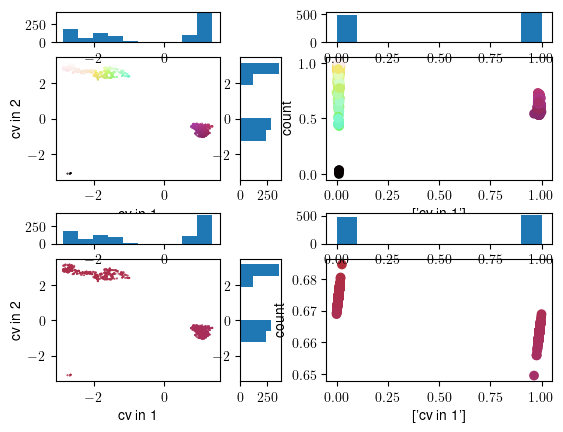

In [22]:


from IMLCV.base.CVDiscovery import CVDiscovery
from IMLCV.implementations.CvDiscovery import TransoformerLDA
from IMLCV.implementations.CV import sb_descriptor

from molmod.units import angstrom


out_dim = 1
r_cut = 4.0 * angstrom


descriptor = sb_descriptor(r_cut=r_cut, n_max=2, l_max=2, reshape=True)
tf = TransoformerLDA(outdim=out_dim, descriptor=descriptor)

scheme0.update_CV(
    samples=1e3,
    split_data=True,
    cvd=CVDiscovery(transformer=tf),
    new_r_cut=r_cut,
    chunk_size=300,
    alpha_rematch=0.05,
    plot=True,
    pre_scale=False,
    sort="rematch",
)


The 2 phases are cleare separated, as desired.

## do new MD run with discovered CV

first, copy the and transform the data points from the previous cv. This will be used as initial data

In [23]:
scheme0.rounds.copy_from_previous_round(  chunk_size=500 )
scheme0.rounds.add_round_from_md(scheme0.md)

In [5]:
from molmod.units import kjmol
scheme0.inner_loop( K = 10*kjmol, rnds=3, n=4,steps=2000, init=0, plot=True)

running round with 2000 steps
Loading MD engine
Loading MD engine
running round with 2000 steps
Loading MD engine
Loading MD engine
running round with 2000 steps
Loading MD engine
Loading MD engine


lets look at the umbrella simulations and the produced Free energy surface

In [2]:
from IPython.display import IFrame
from IPython.display import Image,display
from pdf2image import convert_from_path

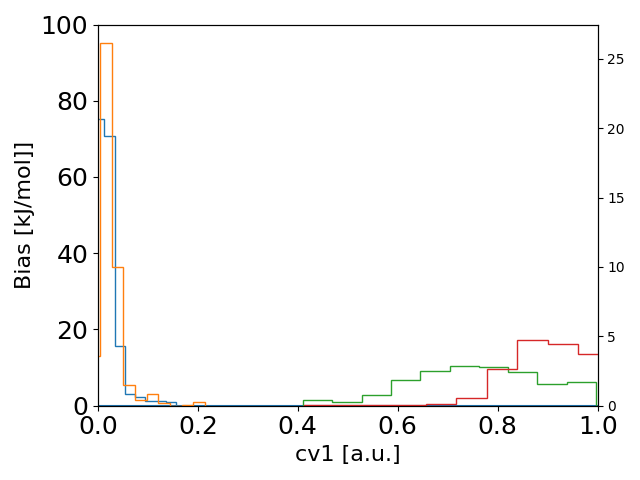

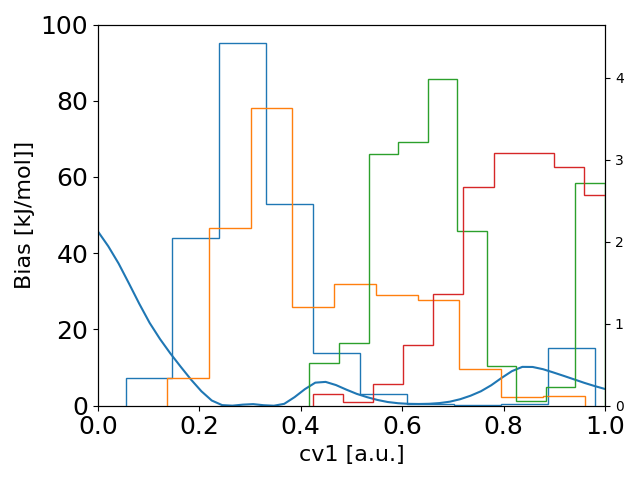

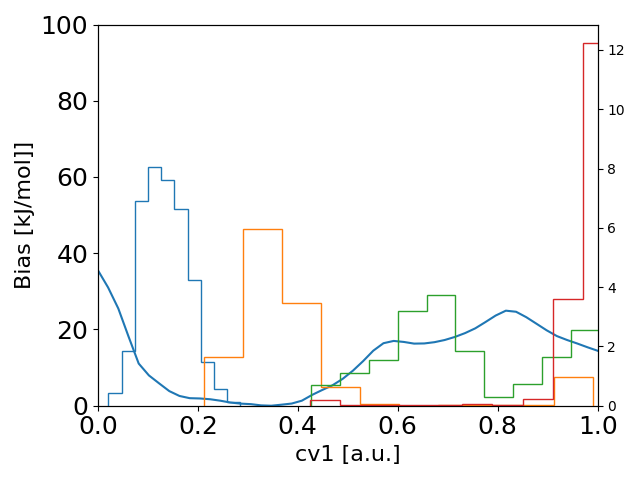

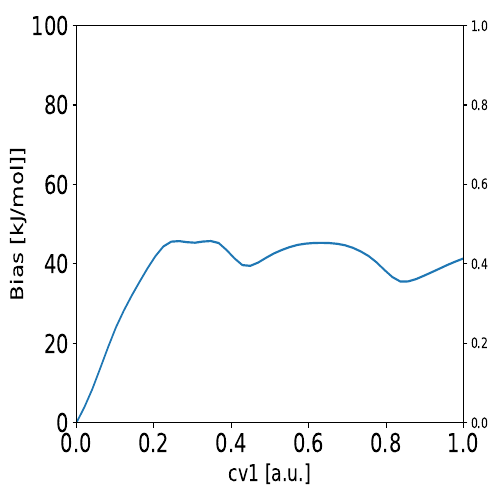

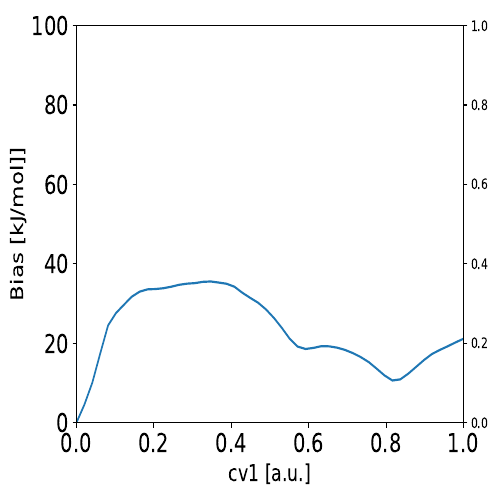

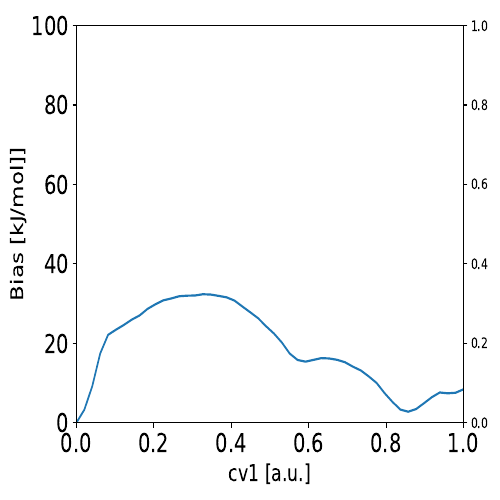

In [9]:
display(  *[Image(   folder/"cv_1"/f"round_{i}"/"combined.png" , width=500  ) for i in range(1,4)]   )
display(  *[ convert_from_path(folder/"cv_1"/f"FES_bias_{i}_inverted_rbf.pdf"  , size=(500,500) , dpi=200  )[0]  for i in range(1,4) ]   )


Clearly, the do not uniformly cover the space (yet) and the free energy surface (FES) is not converged. Nevertheless, we will use this data to generate a new CV already



let's look at the coverage and convergence

## look for new CV wiht UMAP

starting pre_fit
starting fit
Epoch 1/10
327/327 [==============================] - 7s 15ms/step - loss: 0.2984 - reconstruction_loss: 0.0489 - umap_loss: 0.2495
Epoch 2/10
327/327 [==============================] - 5s 15ms/step - loss: 0.1991 - reconstruction_loss: 0.0175 - umap_loss: 0.1816
Epoch 3/10
327/327 [==============================] - 5s 15ms/step - loss: 0.1901 - reconstruction_loss: 0.0158 - umap_loss: 0.1743
Epoch 4/10
327/327 [==============================] - 5s 15ms/step - loss: 0.1845 - reconstruction_loss: 0.0151 - umap_loss: 0.1694
Epoch 5/10
327/327 [==============================] - 5s 15ms/step - loss: 0.1807 - reconstruction_loss: 0.0146 - umap_loss: 0.1661
Epoch 6/10
327/327 [==============================] - 5s 15ms/step - loss: 0.1779 - reconstruction_loss: 0.0142 - umap_loss: 0.1636
Epoch 7/10
327/327 [==============================] - 5s 15ms/step - loss: 0.1769 - reconstruction_loss: 0.0139 - umap_loss: 0.1630
Epoch 8/10
327/327 [==========================

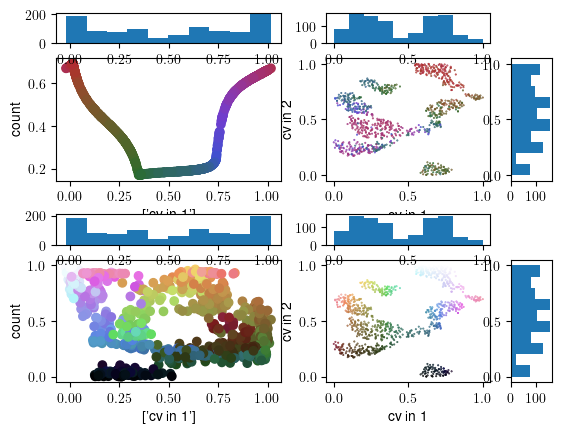

In [15]:
from IMLCV.base.CVDiscovery import CVDiscovery
from IMLCV.implementations.tensorflow.CvDiscovery import TranformerUMAP
from IMLCV.implementations.CV import sb_descriptor
from tensorflow import keras

from molmod.units import angstrom
   


out_dim = 2
r_cut = 4.0 * angstrom


descriptor = sb_descriptor(r_cut=r_cut, n_max=2, l_max=2, reshape=True)


tf = TranformerUMAP(outdim=out_dim, descriptor=descriptor)


cvd = CVDiscovery(
    transformer=tf,
)


scheme0.update_CV(
        samples=1e3,
        cvd=cvd,
        new_r_cut=r_cut,
        chunk_size=200,
        n_neighbors=100,
        min_dist=0.5,
        nunits=50,
        nlayers=3,
        # metric="l2",
        densmap=False,
        parametric_reconstruction=True,
        parametric_reconstruction_loss_fcn=keras.losses.MSE,
        decoder=True,
    
)

### compare with backbone dihedral angles

For alanine dipeptide, the most well-known CVs are the so called backbone dihedral angles. We'll compare them here with our UMAP CVs

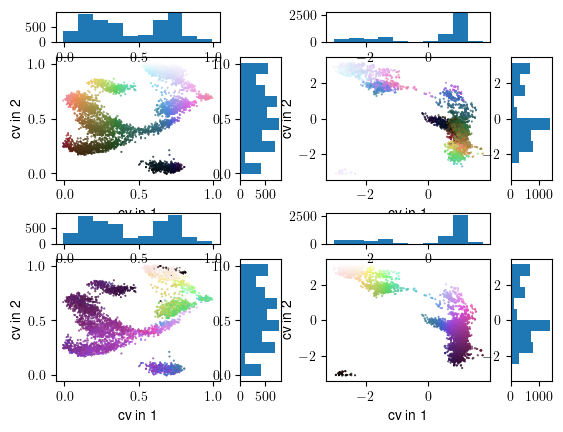

In [16]:
from IMLCV.base.CV import CollectiveVariable,CvMetric
from IMLCV.implementations.CV import dihedral
import numpy as np
from IMLCV.base.CVDiscovery import CVDiscovery

bd_cv0 = CollectiveVariable(
    f=(dihedral(numbers=[4, 6, 8, 14]) + dihedral(numbers=[6, 8, 14, 16])),
    metric=CvMetric(
        periodicities=[True, True],
        bounding_box=[[-np.pi, np.pi], [-np.pi, np.pi]],
    ),
)

umap_cv = scheme0.md.bias.collective_variable

sp,nl,cv,sti,_ =  CVDiscovery.data_loader(  scheme0.rounds,out=5e3,new_r_cut= scheme0.md.static_trajectory_info.r_cut  ,cv_round=1      )


CVDiscovery.plot_app(  name= folder/"cv_2"/"comp_bd.pdf",  sps=  sp[0] ,   nl=  nl[0],   old_cv=umap_cv, new_cv=bd_cv0, chunk_size=300)

This seems a quite reasonable embedding. In lower row, we see that the color gradient matches in both figures. This is a good starting point for a new sampling. Of course, normally we don't have a CV to compare against

### sampling the UMAP CV FES


In [5]:
scheme0.rounds.copy_from_previous_round(  chunk_size=500 )
scheme0.rounds.add_round_from_md(scheme0.md)

In [6]:
scheme0.inner_loop( rnds=3, n=4,steps=1000, init=0, plot=True)

running round with 1000 steps
Loading MD engine
Loading MD engine
running round with 1000 steps
Loading MD engine
Loading MD engine
running round with 1000 steps
Loading MD engine
Loading MD engine


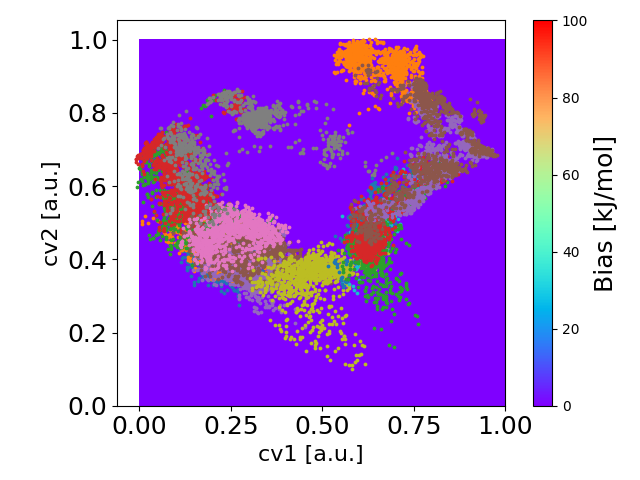

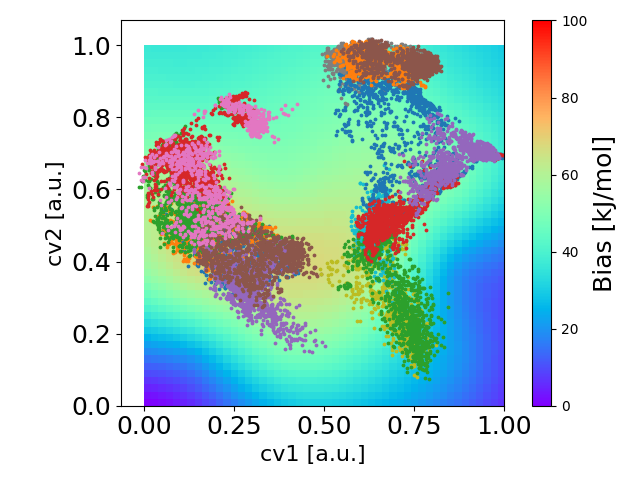

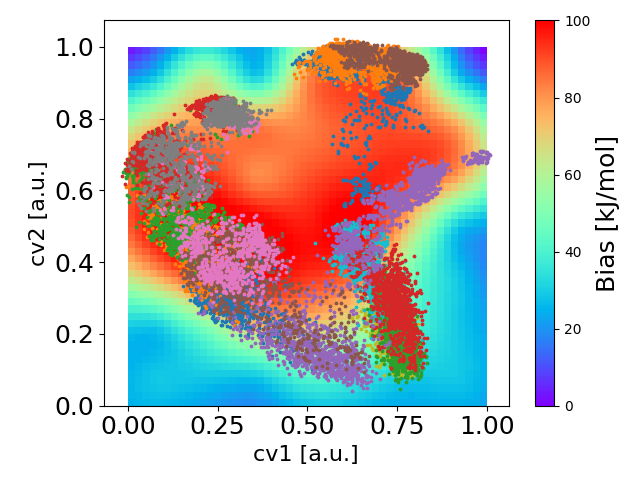

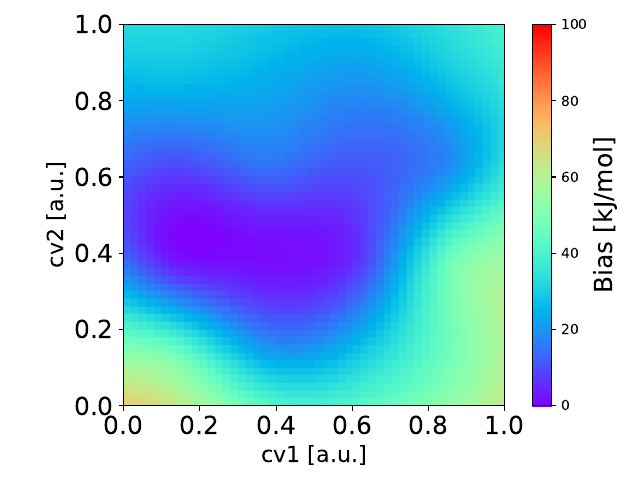

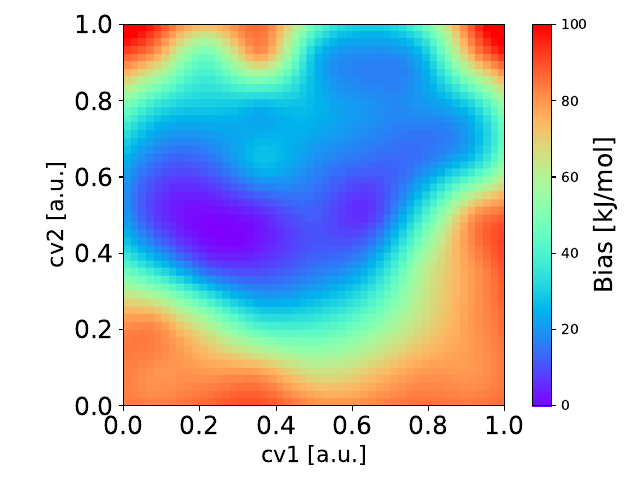

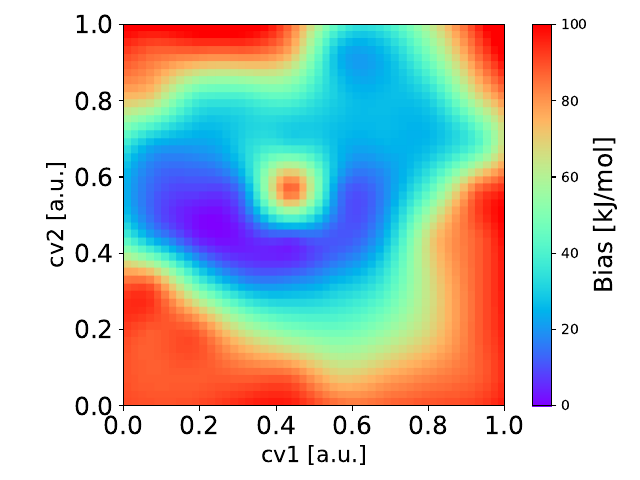

In [11]:
display(  *[Image(   folder/"cv_2"/f"round_{i}"/"combined.png" , width=500  ) for i in range(1,4)]   )
display(  *[ convert_from_path(folder/"cv_2"/f"FES_bias_{i}_inverted_rbf.pdf"  ,  dpi=100  )[0]  for i in range(1,4) ]   )

lets again compare with the bacbone dihedral angles


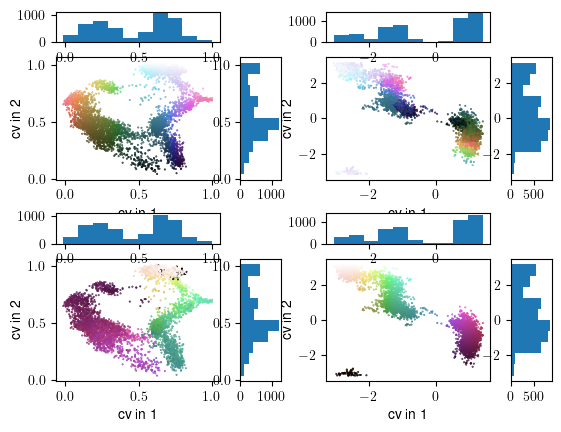

In [12]:
from IMLCV.base.CV import CollectiveVariable,CvMetric
from IMLCV.implementations.CV import dihedral
import numpy as np
from IMLCV.base.CVDiscovery import CVDiscovery

bd_cv0 = CollectiveVariable(
    f=(dihedral(numbers=[4, 6, 8, 14]) + dihedral(numbers=[6, 8, 14, 16])),
    metric=CvMetric(
        periodicities=[True, True],
        bounding_box=[[-np.pi, np.pi], [-np.pi, np.pi]],
    ),
)

umap_cv = scheme0.md.bias.collective_variable

sp,nl,cv,sti,_ =  CVDiscovery.data_loader(  scheme0.rounds,out=5e3,new_r_cut= scheme0.md.static_trajectory_info.r_cut        )
CVDiscovery.plot_app(  name= folder/"cv_2"/"comp_bd.pdf",  sps=  sp[0] ,   nl=  nl[0],   old_cv=umap_cv, new_cv=bd_cv0, chunk_size=300)

the FES looks quite, a more reasonable part of the FES of alanine dipetide is sampled. Let's add a few more rounds

In [13]:
scheme0.inner_loop( rnds=3, n=4,steps=1000, init=0, plot=True, choice="rbf",fes_bias_rnds=4 ,samples_per_bin=300)

running round with 1000 steps
Loading MD engine
Loading MD engine
running round with 1000 steps
Loading MD engine
Loading MD engine
running round with 1000 steps
Loading MD engine
Loading MD engine


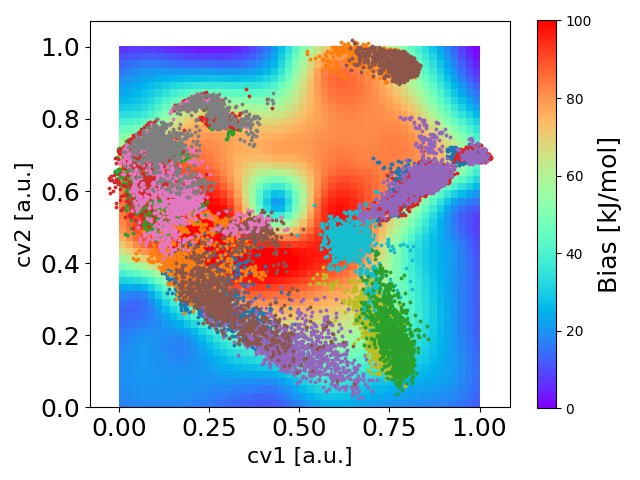

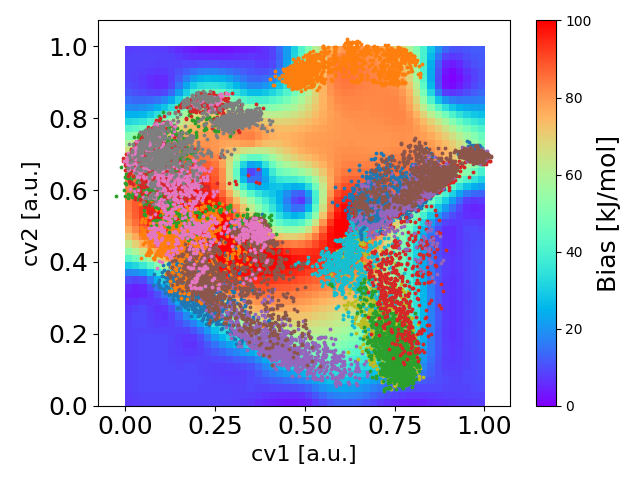

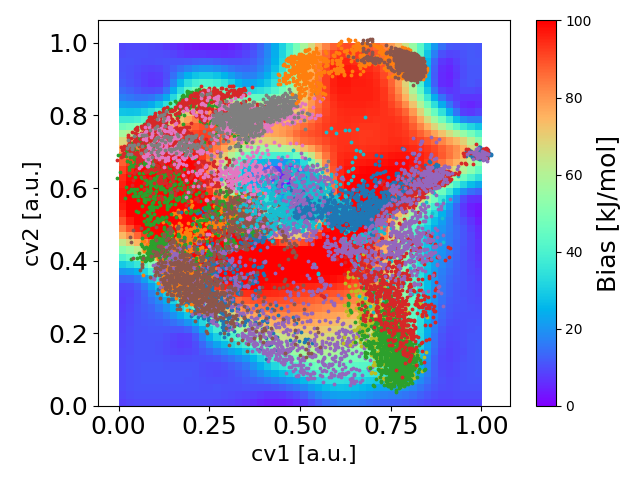

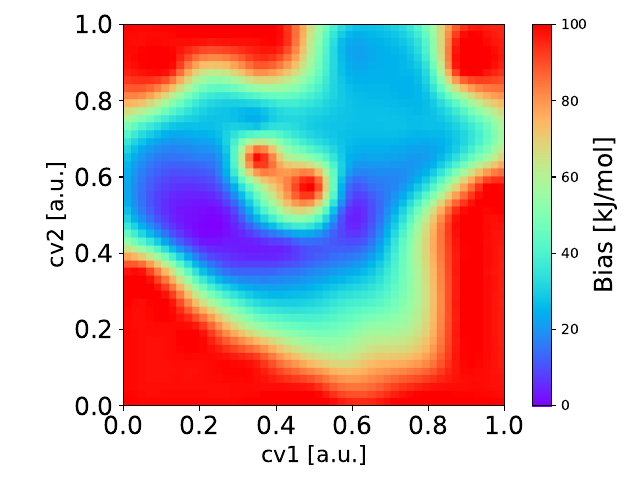

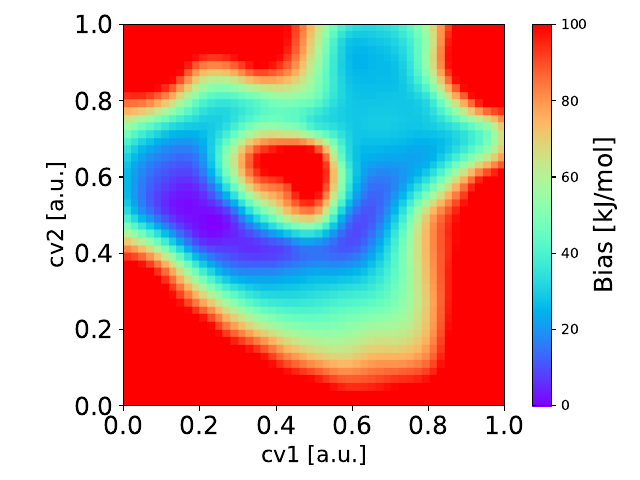

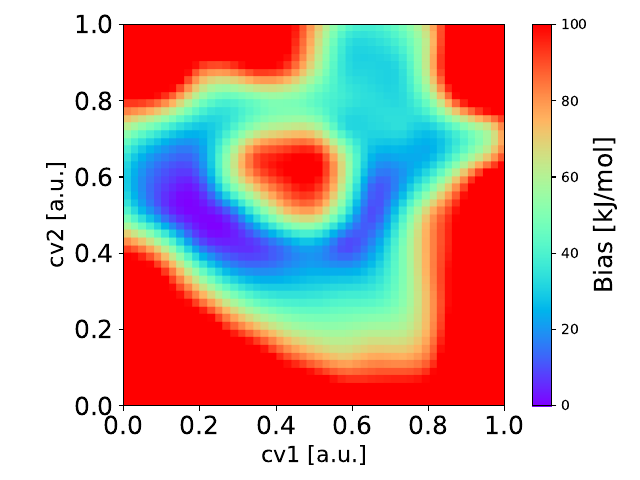

In [16]:
display(  *[Image(   folder/"cv_2"/f"round_{i}"/"combined.png" , width=500  ) for i in range(4,7)]   )
display(  *[ convert_from_path(folder/"cv_2"/f"FES_bias_{i}_inverted_rbf.pdf"  ,  dpi=100  )[0]  for i in range(4,7) ]   )

The 2 stable phases are now clearly visible, and the profile has more or less converged. Lets now sample the grid more finely, to reveal the smaller details in the FES. Also, only rely on data from the last round

In [17]:
scheme0.inner_loop( rnds=1, n=8,steps=2000, init=0, plot=True, choice="rbf",fes_bias_rnds=1 ,samples_per_bin=200)

running round with 2000 steps
Loading MD engine
Loading MD engine


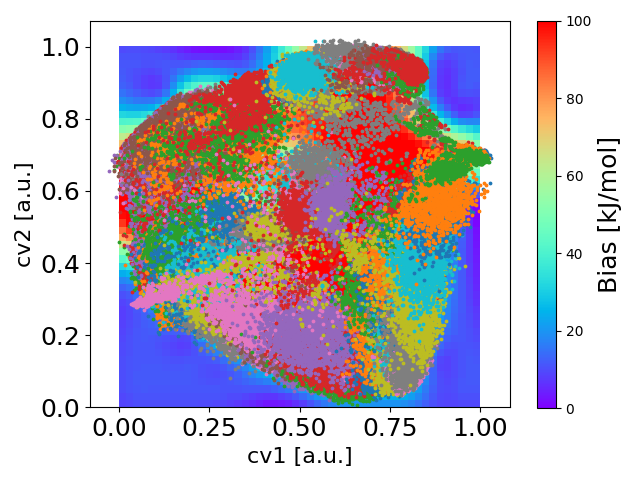

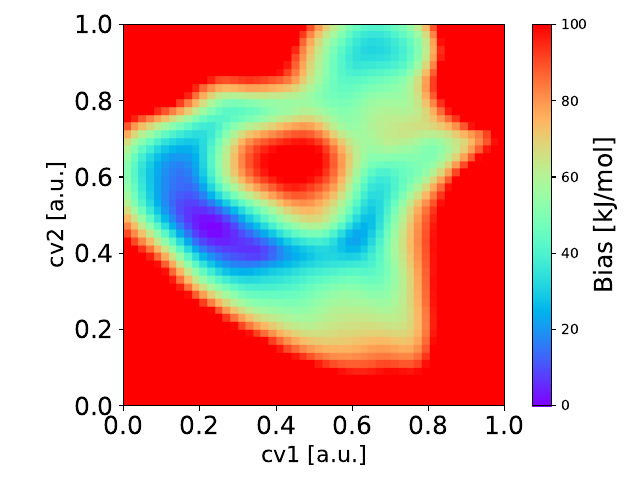

In [22]:
display(  *[Image(   folder/"cv_2"/f"round_{i}"/"combined.png" , width=500  ) for i in [7] ]   )
display(  *[ convert_from_path(folder/"cv_2"/f"FES_bias_{i}_inverted_rbf.pdf"  ,  dpi=100  )[0]  for i in [7] ]   )

In [23]:
from IMLCV.base.CV import CollectiveVariable,CvMetric
from IMLCV.implementations.CV import dihedral
import numpy as np
from IMLCV.base.CVDiscovery import CVDiscovery

bd_cv0 = CollectiveVariable(
    f=(dihedral(numbers=[4, 6, 8, 14]) + dihedral(numbers=[6, 8, 14, 16])),
    metric=CvMetric(
        periodicities=[True, True],
        bounding_box=[[-np.pi, np.pi], [-np.pi, np.pi]],
    ),
)

umap_cv = scheme0.md.bias.collective_variable

sp,nl,cv,sti,_ =  CVDiscovery.data_loader(  scheme0.rounds,out=5e3,new_r_cut= scheme0.md.static_trajectory_info.r_cut    , num=2    )
CVDiscovery.plot_app(  name= folder/"cv_2"/"comp_bd.pdf",  sps=  sp[0] ,   nl=  nl[0],   old_cv=umap_cv, new_cv=bd_cv0, chunk_size=300)

## transforming the profile

In [5]:

import jax.numpy as jnp
from IMLCV.implementations.CV import affine_2d


affine_trans = affine_2d(jnp.array([[-1.4, 0.2],
                                    [-0.1, 1.4], 
                                    [1.1, -0.55],
                             [0.2, -1.5]]),
                  jnp.array([[-1, -1],
                             [-1, 1],
                             [1, 1],
                             [1, -1]]),
                  )

scheme0.transform_CV( affine_trans , copy_samples=False, plot=True  )


In [7]:
scheme0.md.bias.compute_from_system_params( sp=scheme0.md.sp,nl=scheme0.md.nl )

(CV(cv=Array([ 0.49038778, -0.31518263], dtype=float64), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None),
 EnergyResult(energy=Array(0.05047606, dtype=float64), gpos=None, vtens=None))